# Find Sine delay in Beacon

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import signal


import os
import sys
# Append parent directory to import path so lib can be found
sys.path.append(os.path.dirname(os.path.abspath(os.getcwd())))
from lib.util import *

from lib.timing import *

In [2]:
us = 1e3 # ns
ns = 1/us # us

samplerate = 500 # MHz
timelength = 0.2 # us


beacon_time = np.arange(0, timelength, 1/samplerate)
f_beacon = 70 # MHz


beacon_init_phase = phase2time(42/ns, f_beacon)
beacon_phase_offset = 1.2*np.pi

beacons = np.array([
    sin_delay(f_beacon, beacon_time, phase=-beacon_init_phase),
    sin_delay(f_beacon, beacon_time, phase=-beacon_init_phase-beacon_phase_offset)
])

ref_time = np.arange(0, 1/f_beacon, 1/samplerate)
ref_beacon = sin_delay(f_beacon, ref_time, t_delay=0, phase=0)

### Reference Delay

Cheat Time Delay [ns]: 2.8311078050095477 \pm [0. 0.]
Calculated Time Delay [ns]: 2.857142857142857 \pm [-1.  1.]


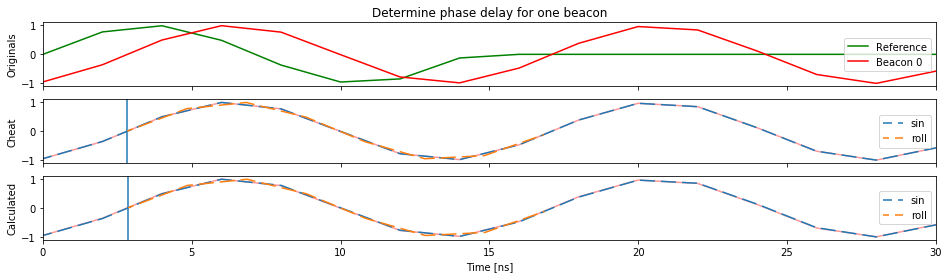

In [3]:
show_originals = True


fig, axes = plt.subplots(3,1, sharex=True, figsize=(16,4))
axes[0].set_title("Determine phase delay of a single beacon")
axes[-1].set_xlabel("Time [ns]")

## Originals
i=0
axes[i].set_ylabel("Originals")
axes[i].plot(beacon_time/ns, 
             np.pad(ref_beacon, (0,len(beacons[0])-len(ref_beacon)), 'constant', constant_values=0), 
             label="Reference",
             color='g')
axes[i].plot(beacon_time/ns, 
             beacons[0], 
             label="Beacon 0",
             color='r'
            )
axes[i].legend(loc='center right')

for i in range(1, 3):    
    if i == 1:
        label = "Cheat"
        time_delay = phase2time(phase_modulo(beacon_init_phase,0), f_beacon)
        time_delay_err = np.array([0,0])

        
    ## Calculated
    else:
        label = "Calculated"
        phase_delay, phase_err = beacon_phase_delay(samplerate, f_beacon, ref_beacon, beacons[0])
        time_delay = phase2time(phase_modulo(phase_delay, 0), f_beacon)
        time_delay_err = phase2time(phase_err, f_beacon)
    
    axes[i].set_ylabel(label)
    print("{} Time Delay [ns]: {} \pm {}".format(label, time_delay/ns, time_delay_err/ns))

    ### Show original
    if show_originals:
        axes[i].plot(beacon_time/ns, 
                     beacons[0],
                     color='r', alpha=0.4
                    )

    axes[i].axvline(time_delay/ns)
    axes[i].plot(beacon_time/ns,
                 sin_delay(f_beacon, beacon_time, t_delay=time_delay),
                 ls = (4, (10, 4)),
                 label='sin')
    axes[i].plot((ref_time+time_delay)/ns,
                 ref_beacon,
                 ls = (6, (10, 4)),
                 label='roll')
    axes[i].legend(loc='center right')

axes[0].set_xlim(0, 30)
fig.show()

### Determine delay between beacons

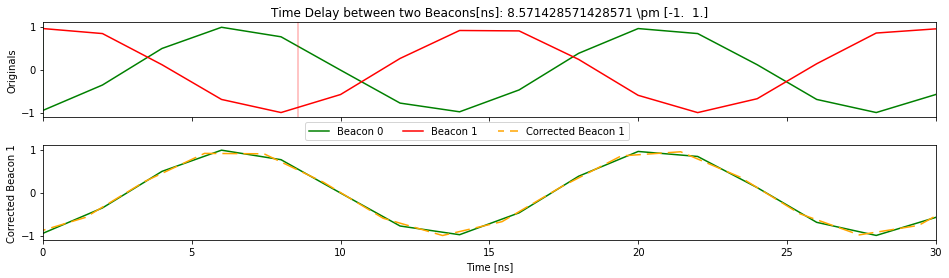

In [5]:
abs_time_delay, time_delay_err = beacon_time_delay(samplerate, beacons[0], beacons[1])
time_delay = abs_time_delay % (1/f_beacon)


fig, axes = plt.subplots(2, sharex=True, figsize=(16,4))
axes[-1].set_xlabel("Time [ns]")
axes[0].set_title("Time Delay between two Beacons[ns]: {} \pm {}".format(time_delay/ns, time_delay_err/ns))


## Originals
i=0
axes[i].set_ylabel("Originals")
axes[i].plot(beacon_time/ns, 
             beacons[0], 
             label="Beacon 0",
             color='g')
axes[i].plot(beacon_time/ns, 
             beacons[1], 
             label="Beacon 1",
             color='r'
            )
axes[i].axvline(0, color='g', alpha=0.3)
axes[i].axvline(time_delay/ns, color='r', alpha=0.3)

## Correct Beacon 1
i=1
axes[i].set_ylabel("Corrected Beacon 1")
axes[i].plot(beacon_time/ns, 
             beacons[0], 
             #label="Beacon 0",
             color='g',
            )
axes[i].plot((beacon_time-time_delay)/ns,
             beacons[1],
             ls = (6, (10, 4)),
             color='orange',
             label='Corrected Beacon 1'
            )

axes[0].set_xlim(0, 30)
# put legend between plots
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

fig.subplots_adjust(hspace=0.3)
fig.legend(lines, labels ,loc='right', ncol=3, bbox_to_anchor=(0.55, 0.51))
fig.show()